<a href="https://colab.research.google.com/github/qmcsuzuki/QMCexamples/blob/main/QMCintegration/QMC_expsum_randomize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qmcpy --quiet
import qmcpy
import numpy as np
from matplotlib import pyplot as plt

## 実験の目的

被積分関数を $f(x) = \exp\left(\sum_{j=1}^s w_jx_j\right)$ とする。
ランダマイズされたSobol'列、Halton 列の誤差の収束を観察する。

単一サンプルの誤差収束、分散の誤差収束を確認する。

---

以下、必要な関数を定義する


In [2]:
def expsum(points,weights,C):
    """
    Args:
      points: N*d ndarray, points to evaluate
      weights: d-dim vector, weights for each dimension
      C: (normalization) constant
    Returns: N-dim vector, exp(sum(w1*x1+...+ws*xs))/C for each point
    """
    return np.exp(np.sum(points*weights,1))/C

def make_normalized_expsum(weights):
    C = np.prod((np.exp(weights)-1)/weights)
    return lambda points: expsum(points,weights,C)


In [3]:
def make_errortable(integrand, Points, Mmax, truevalue=1):
    """ Points の最初の 2^1, ..., 2^{Mmax} 点での，integrand のQMC積分誤差のテーブルを返す
    integrand: 被積分関数
    Points: N*d ndarray (d-dimensional N points)
    """
    error = np.zeros(Mmax)
    for m in range(1,Mmax+1):
        x = np.mean(integrand(Points[:1<<m,:]))
        error[m-1] = np.abs(x-truevalue)
    return error


def make_errorplot(Errors, labels, slopes, savefilename):
    """ Errors の各 Error 配列の中身を loglog プロットする
    Errors: 長さ Mmax の配列のリスト
    labels: 名前のリスト
    slopes: 凡例に表示する傾き
    """
    plt.figure(figsize=(10, 6))
    linestyles = ['-', '--',  ':', '-.']
    markers = ['o', '^', 'x', 'D']

    for i,error in enumerate(Errors):
        plt.semilogy(np.arange(1,Mmax+1), error, color='black', linestyle=linestyles[i], marker=markers[i], markerfacecolor='none', label=labels[i])

    for slope in slopes:
        x = np.arange(1, Mmax+1)
        y = 2.0**(slope*x)
        plt.semilogy(x, y, color='gray', linestyle='--', label=f'Slope={slope}')

    plt.xticks(np.arange(1, Mmax+1, 2),fontsize=16)  # X軸の目盛りを2刻みに
    plt.yticks(fontsize=16)  # Y軸の目盛りを大きく
    plt.xlim(0,Mmax+0.1)
    plt.ylim(10**-6, 10**0)  # Y軸の範囲を固定
    plt.legend(fontsize=16)

    plt.savefig(savefilename,format="pdf",bbox_inches='tight')
    plt.show()


In [4]:
def experiment_onesample(s,Mmax,weights,randomize,savefilename):
    """
    被積分関数 f(x)=exp(sum(w[j]*x[j]))  とする
    Sobol, Halton, Random による積分誤差をプロットする
    """
    sobol = qmcpy.Sobol(dimension=s,randomize=randomize).gen_samples(1<<Mmax)
    halton = qmcpy.Halton(dimension=s,randomize=randomize).gen_samples(1<<Mmax)
    random = qmcpy.IIDStdUniform(dimension=s).gen_samples(1<<Mmax)

    samplers = [sobol,halton,random]
    integrand = make_normalized_expsum(weights)

    labels = ["Sobol'",'Halton','Random']
    Errors = [make_errortable(integrand, points, Mmax) for points in (sobol,halton,random)]
    make_errorplot(Errors, labels, slopes=[-1.5,-1,-0.5],savefilename=savefilename)


In [5]:
def experiment_Rsamples(s,Mmax,R,weights,savefilename):
    integrand = make_normalized_expsum(weights)

    samplers = [qmcpy.Sobol,qmcpy.Halton,qmcpy.IIDStdUniform]
    labels = ["Sobol'",'Halton','Random']

    Devs = []
    for i,sampler in enumerate(samplers):
        Errors = np.zeros((R,Mmax))
        for r in range(R):
            points = sampler(s).gen_samples(1<<Mmax)
            Errors[r,:] = make_errortable(integrand, points, Mmax)
        stddev = np.std(Errors,axis=0)
        Devs.append(stddev)

    make_errorplot(Devs, labels, slopes=[-1.5,-1,-0.5],savefilename=savefilename)

---

## 実験

$s = 4$, 重みなしとして、
ランダマイズされたソボル、格子、ハルトンを 1 系列ずつ発生させて誤差の収束を見る

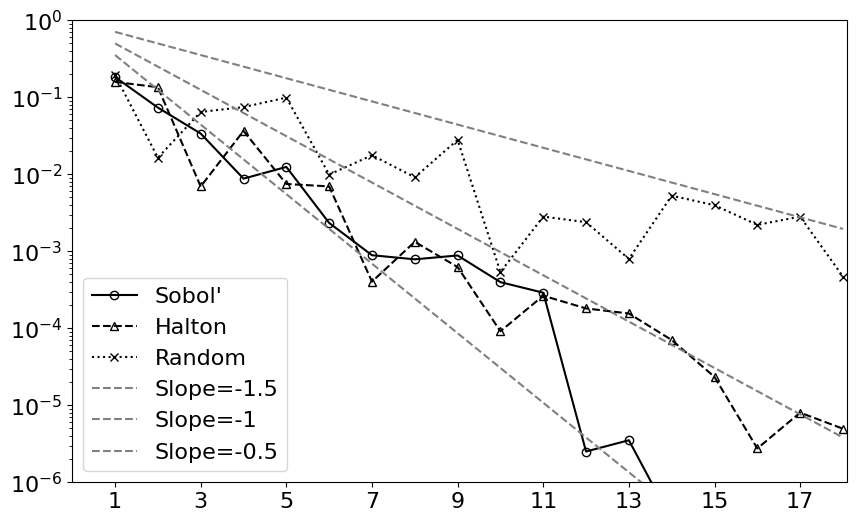

In [6]:
s = 4
Mmax = 18
weights = np.ones(s)
savefilename=f"{s}dim-unweighted"

experiment_onesample(s,Mmax,weights,True,savefilename)

## 実験結果

ランダマイズをした点集合（単一サンプル）で誤差を比較すると、典型的には

- Sobol' 列は $O(N^{-1.5})$ に近い収束
- 格子、Halton 列は $O(N^{-1})$ に近い収束

が見られる

---


## 実験

$s = 4$, 重みなしとして、
繰り返しの回数を $R = 50$ として、得られた推定値の標準偏差を計算する。


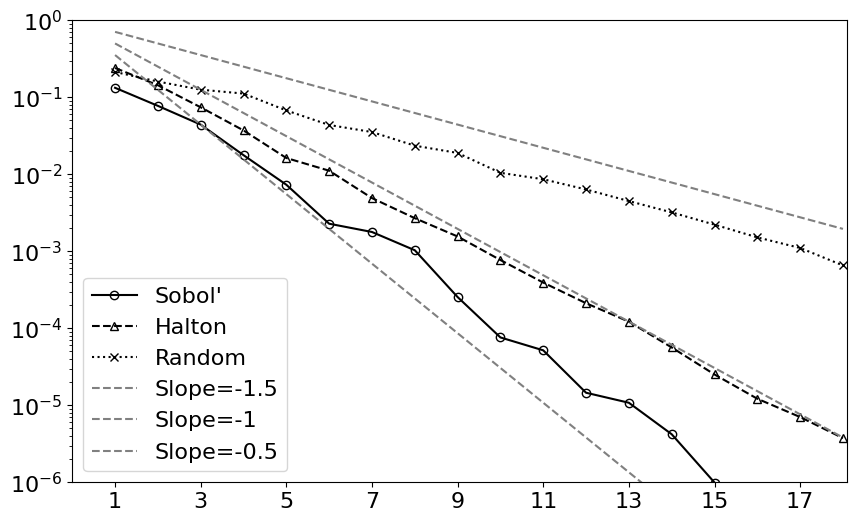

In [7]:
s = 4
Mmax = 18
R = 50
weights=np.ones(s)
savefilename=f"{s}dim-unweighted-RQMCdeviation"

experiment_Rsamples(s,Mmax,R,weights,savefilename)

## 実験結果

標準偏差の収束も、

- Sobol' 列は $O(N^{-1.5})$ に近い収束
- Halton 列は $O(N^{-1})$ に近い収束
- 乱数列は $O(N^{-0.5})$ に近い収束

が見られる

---



## 実験

$s=20$ の場合に、重みなし、重みつきそれぞれの観察する



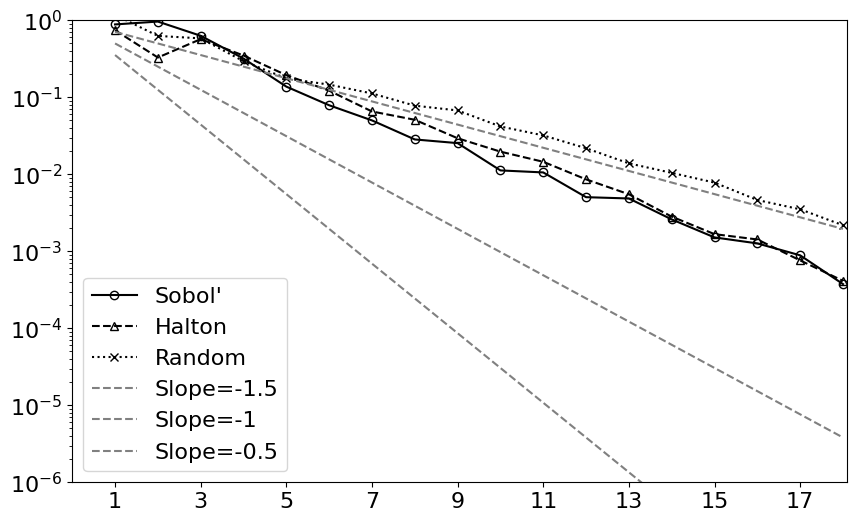

In [8]:
s = 20
Mmax = 18
R = 50
weights=np.ones(s)
savefilename=f"{s}dim-unweighted-RQMCdeviation"

experiment_Rsamples(s,Mmax,R,weights,savefilename)

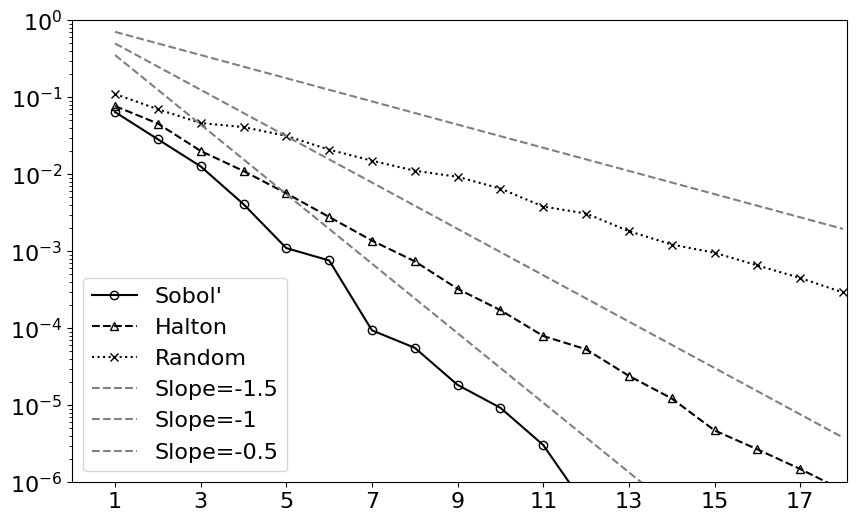

In [9]:
s = 20
Mmax = 18
R = 50
weights = 1/np.arange(1,s+1)**2
savefilename=f"{s}dim-weighted-RQMCdeviation"

experiment_Rsamples(s,Mmax,R,weights,savefilename)

## 実験結果

重みなしの場合、どの系列の分散も大して変わらないという結果が得られた

一方で重みありの場合、$s=4$の場合と同様に

- Sobol' 列は $O(N^{-1.5})$ に近い収束
- Halton 列は $O(N^{-1})$ に近い収束
- 乱数列は $O(N^{-0.5})$ に近い収束

が観察できた